# Lecture 22 - Convolutional Neural Networks (CNNs)

In the last few years, CNNs have become popular in the areas of image recognition, object detection, segmentation, and many other tasks in the field of computer vision. They are also becoming popular in the field of **natural language processing (NLP)**.

The fundamental difference between fully connected layers and convolution layers is the way the weights are connected to each other in the intermediate layers.

One of the biggest challenges of using a linear layer or fully connected layers for computer vision is that they lose all spatial information, and the complexity in terms of the number of weights used by fully connected layers is too big. For example, when we represent a $224\times 224$ color image as a flat array, we would end up with $150 528$-dimensional feature vector ($224 \times 224 \times 3$). When the image is flattened, we lose all the spatial information.

There is a better way! It consists in replacing the dense, fully-connected affine transformation in our neural network unit with a different linear operation: **convolution**.

Example: if we ought to recognize patterns corresponding to objects, like an airplane in the sky, we will likely need to look at how nearby pixels are arranged, and we would be less interested at how pixels that are far from each other appear in combination. Essentially, it doesn't matter if our image of a Spitfire has a tree or cloud or kite in the corner or not.

In order to translate this intuition in mathematical form, we could compute the weighted sum of a
pixel with its immediate neighbors, rather than with all other pixels in the image. This would be
equivalent to building weight matrices, one per output feature and output pixel location, in which
all weights beyond a certain distance from a center pixel are zero. This will still be a weighted
sum, i.e. a linear operation.

We would like these localized patterns to have an effect on the output no matter their location in the image, i.e. to be *translation-invariant*. 

To do that, we would need to force the weights in each per-output-pixel family of patterns to have same values, regardless of pixel location. To achieve this goal, we would need to initialize all weight matrices in a family with the same values, and, during back-propagation, average the gradients for all pixel locations and apply that average as the update to all weights in the family.

For this reason, CNNs are often called **shared weight neural networks**. This is because several connections in the network are tied together to have the same value.

<div><img src="figures/convolution.png", width="700"><!div>

When we switch standard fully connected networks (MLPs) with CNNs, we get:

* local operations on neighborhoods
* translation-invariance
* models with a lot fewer parameters

## CNNs: Shared-Weight Neural Networks

Consider a 2-D convolution (used, for example, in image processing):

$$g(x,y) \ast f(x,y) = \sum_{s=-a}^a \sum_{t=-b}^b g(s,t) f(x-s, y-t)$$

where $g$ is the filter and $f$ is the image to be convolved. Essentially, we flip both horizontally and vertically and, then, slide $g$ accross $f$ where at each location we perform a pointwise multiplication and then a sum.

To understand better how are we exactly creating a neural network that extracts features using convolution operations, we need to first consider that a convolutional can be written as a *linear operation* with a **doubly block circulant matrix**.

$$H(x,y) = F(x,y) \ast g(x,y)$$

is the same as

$$h = Gf$$

where $f$ and $h$ are the vectorized forms of $F$ and $G$ is a doubly block circulant matrix.

Consider the following small image:

$$Im = \left[\begin{array}{cccc}
1 & 2 & 3 & 4\\
5 & 6 & 7 & 8\\
9 & 10 & 11 & 12\\
13 & 14 & 15 & 16
\end{array}\right]$$

We can vectorize it and obtain:

$$I^T = [1,2,3,\dots, 14,15,16]$$

Let's consider the following kernel:

$$k = \left[\begin{array}{ccc}
-1 & -2 & -3\\
-4 & -5 & -6\\
-7 & -8 & -9
\end{array}\right]$$

Let $G$ be:

$$G = \left[\begin{array}{cccccccccccccccc}
-1 & -2 & -3 & 0 & -4 & -5 & -6 & 0 & -7 & -8 & -9 & 0 & 0 & 0 & 0 & 0\\
0 & -1 & -2 & -3 & 0 & -4 & -5 & -6 & 0 & -7 & -8 & -9 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & -2 & -3 & 0 & -4 & -5 & -6 & 0 & -7 & -8 & -9 & 0\\
0 & 0 & 0 & 0 & 0 & -1 & -2 & -3 & 0 & -4 & -5 & -6 & 0 & -7 & -8 & -9\\
\end{array}\right]$$

So, we can write the convolution as:

$$GI$$

<div><img src="figures/filters.png", width="700"><!div>

### Kernel/Filter Sizes

Small kernels, like $3 \times 3$ or $5 \times 5$ provide very local information. The problem is how do we know that big picture all structures in our images are 3 pixels or 5 pixels wide?

In order to identify larger objects in an image we will need large convolution kernels. Well, sure, at the limit we could get a
$32 \times 32$ kernel for a $32 \times 32$ image, but we would converge to the old fully connected, affine transformation and lose all the nice properties of convolution. 

Another option, which is what is used in convolutional neural networks, is stacking one convolution after the other, and at the same time downsampling the image in-between successive convolutions.

![CNNs](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Typical_cnn.png/593px-Typical_cnn.png)

So, on one hand, the first set of kernels operates on small neighborhoods on first-order, low-level features, while the second set of kernels effectively operates on wider neighborhoods, producing features that are compositions of the previous features. This is a very powerful mechanism that provides convolutional neural networks with the ability to see into very complex scenes

### Pooling Layers & Strides

Downsampling could in principle occur in different ways. Scaling an image by a half is the equivalent of taking 4 neighboring pixels in input and producing one pixel in output. How we compute the value of the output based on the values of the input is up to us. We could:

* **Average-pooling**: average the four pixels. This was a common approach early on, but has since fallen out of favor somewhat.
* **Max-pooling**: take the maximum of the four pixels. This is currently the most commonly used approach, but has a downside of discarding the other 3/4ths of the data.
* **Stride**: perform a strided convolution, where only every Nth pixel is calculated. A 3x4 convolution with stride 2 still incorporates input from all pixels from the previous layer. Current literature shows promise for this approach, but it has not yet supplanted maxpool.

<div><img src="figures/maxpooling.png", width="700"><!div>

Intuitively, the output images from a convolution layer, especially since they are followed by an activation just like any other linear layer, will tend to have a high magnitude where certain features corresponding to the estimated kernel are detected (e.g. vertical lines). By keeping the highest value in the 2x2 neighborhood as the downsampled output, we ensure that the features that have been found survive the downsampling, at the expense of the weaker responses.

<div><img src="figures/CNN.png", width="700"><!div>

In deep learning, we let kernels get estimated from data, in a way that the discrimination is most effective. For instance, in terms of non-negative log likelihood of the output compared to ground truth. From this angle, the job of a convolutional neural network is to estimate the kernel of a set of filter banks in successive layers, that will transform a multi-channel image into another multi-channel image, where different channels will correspond to different features (e.g. one channel for the average, another channel for vertical edges, etc).

# Example Implementation of CNN in PyTorch

Recal the CIFAR-10 data set that consists of 60,000 32x32 color (RGB) images, labeled with an integer corresponding to 10 classes, namely airplane (0), automobile (1), bird (2), cat (3), deer (4), dog (5), frog (6), horse (7), ship (8), truck (9).

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from torchvision import datasets
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

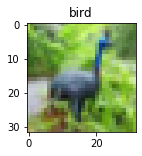

In [4]:
img, label = cifar10[6]

plt.figure(figsize=(2,2))
plt.imshow(img)
plt.title(class_names[label])
plt.show()

In [5]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))]))

Files already downloaded and verified


In [6]:
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))]))

Files already downloaded and verified


In [7]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [8]:
connected_model = nn.Sequential(
    nn.Linear(3072,1024),nn.Tanh(),
    nn.Linear(1024,512), nn.Tanh(),
    nn.Linear(512,128), nn.Tanh(),
    nn.Linear(128,2))

In [9]:
numel_list = [p.numel() for p in connected_model.parameters() if p.requires_grad==True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [10]:
first_model = nn.Sequential(
    nn.Linear(3072,512),nn.Tanh(),
    nn.Linear(512,2), nn.LogSoftmax(dim=1))

In [11]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [12]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [13]:
conv = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [14]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [15]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

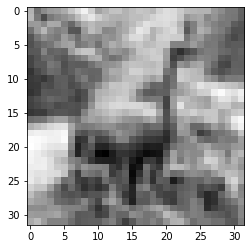

In [16]:
plt.imshow(img.mean(0), cmap='gray');

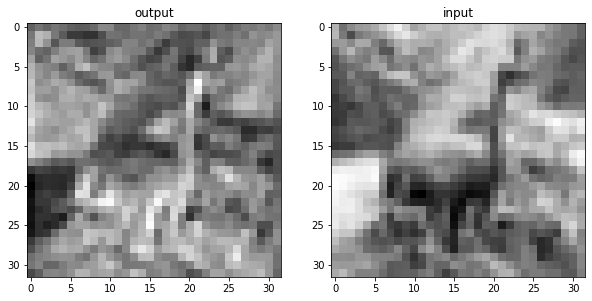

In [17]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

In [18]:
conv = nn.Conv2d(3, 1, kernel_size = 3, padding = 1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [19]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

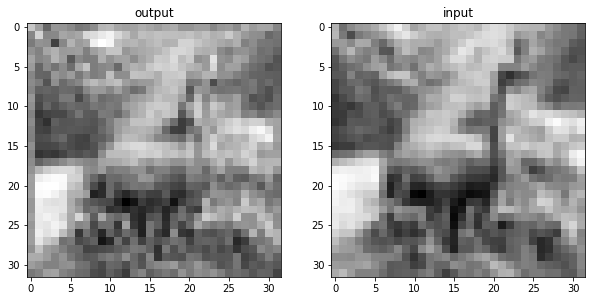

In [20]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

In [21]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

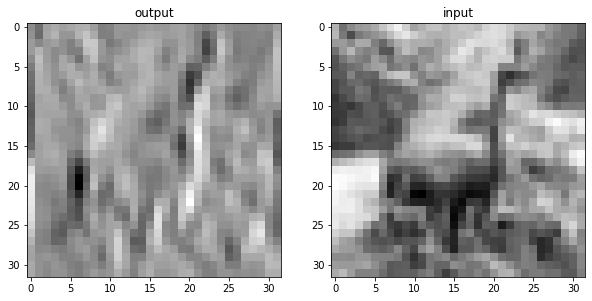

In [22]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

In [23]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [24]:
model = nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    ###
    nn.Linear(8*8*8, 32),
    nn.Tanh(),
    nn.Linear(32,2))

In [25]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [26]:
model(img.unsqueeze(0))

RuntimeError: size mismatch, m1: [64 x 8], m2: [512 x 32] at C:\w\1\s\tmp_conda_3.7_105232\conda\conda-bld\pytorch_1579085620499\work\aten\src\TH/generic/THTensorMath.cpp:136

What's missing there is the reshaping step from a 8-channel 8x8 image to a 512-element, 1D vector.

In [27]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) #reshape
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [28]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

### Functional API

PyTorch has counterparts of *functional* every nn module. By "functional" here we mean "having no internal state", or, in other words, "whose output value is solely and fully determined by the value input arguments".

In [29]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [30]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0625, -0.1651]], grad_fn=<AddmmBackward>)

In [31]:
import datetime 

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  
        loss_train = 0.0
        for imgs, labels in train_loader: 
            outputs = model(imgs)  
            loss = loss_fn(outputs, labels) 

            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()

            loss_train += loss.item() 

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader)))

Datasets and DataLoaders provide a simple, yet effective abstraction for loading datasets and sampling them.

In [32]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-03-30 13:54:00.401032 Epoch 1, Training loss 0.5902499784329894
2020-03-30 13:55:37.631170 Epoch 10, Training loss 0.33370421342788986
2020-03-30 13:57:21.839020 Epoch 20, Training loss 0.29583757062246846
2020-03-30 13:59:05.472003 Epoch 30, Training loss 0.27405275470891577
2020-03-30 14:00:58.975515 Epoch 40, Training loss 0.2516200122464994
2020-03-30 14:03:09.366571 Epoch 50, Training loss 0.23542992443225946
2020-03-30 14:05:06.999725 Epoch 60, Training loss 0.2139802335458956
2020-03-30 14:06:55.369583 Epoch 70, Training loss 0.20072952102703653
2020-03-30 14:08:51.373584 Epoch 80, Training loss 0.18530898417826672
2020-03-30 14:10:50.189922 Epoch 90, Training loss 0.17292601634172877
2020-03-30 14:12:49.694483 Epoch 100, Training loss 0.16020157116993217


In [33]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=True)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]  
                correct += int((predicted == labels).sum()) 

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.88


### Time is $$

In [34]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplane.pt')

In [35]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplane.pt'))

<All keys matched successfully>

In [36]:
loaded_model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)